# image2image

## 导包

In [112]:
from sklearn.utils import resample
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import itertools
import time
from torchvision import utils
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

## 数据预处理

In [113]:
# 坐标系变换
def transform_coordinates(df):
    df['tMouse_X'] = df['tMouse_X'] - (df['RectLeft'] + df['TargetWidth'] / 2)
    df['Mouse_Y'] = -(df['Mouse_Y'] - (df['RectTop'] + df['TargetWidth'] / 2))

    angle_rad = np.deg2rad(-df['DirectionAngle'])
    tmpX = df['tMouse_X'] * np.cos(angle_rad) - df['Mouse_Y'] * np.sin(angle_rad)
    tmpY = df['tMouse_X'] * np.sin(angle_rad) + df['Mouse_Y'] * np.cos(angle_rad)
    
    df['tMouse_X'] = tmpX
    df['Mouse_Y'] = tmpY
    
    return df

# 去离群值
def clear_iso(df):
    
    mean_y = df['Mouse_Y'].mean()
    std_y = df['Mouse_Y'].std()
    mean_x = df['tMouse_X'].mean()
    std_x = df['tMouse_X'].std()
    df = df[(df['tMouse_X'] > mean_y - 3 * std_y) & (df['tMouse_X'] < mean_y + 3 * std_y)]
    df = df[(df['Mouse_Y'] > mean_x - 3 * std_x) & (df['Mouse_Y'] < mean_x + 3 * std_x)]
    return df

# 将落点平移到第一象限
def translation(df):
    df['tMouse_X'] -= df['tMouse_X'].min()
    df['Mouse_Y'] -= df['Mouse_Y'].min()
    return df

# 将落点居中
def centering(df, target_center_X, target_center_Y):
    current_center_X = df['tMouse_X'].mean()
    current_center_Y = df['Mouse_Y'].mean()
    offset_X = target_center_X - current_center_X
    offset_Y = target_center_Y - current_center_Y
    df['tMouse_X'] += offset_X 
    df['Mouse_Y'] += offset_Y
    return df

# 获取采样后图形，目前为np.array格式
def data_augmentation(df, width, velocity, repetitions, fraction):
    filterdata = df[(df['TargetWidth'] == width) & (df['Velocity'] == velocity)]
    filterdata = clear_iso(filterdata)
    images = []
    for _ in range(repetitions):
        sampledata = filterdata.sample(frac=fraction, replace=False)
        sampledata = translation(sampledata)
        sampledata = centering(sampledata, 128, 128)
        image = np.zeros((256, 256), dtype=float)
        for _, row in sampledata.iterrows():
            x, y = int(row['tMouse_X']), int(row['Mouse_Y'])\
            # 暂时先不考虑点重合的问题
            image[y][x] = 1
        images.append(image)
    return images

# 获取目标图像
def get_target(width, velocity):
    image = np.zeros((256, 256), dtype=float)
    center_y, center_x = 128, 128
    for y in range(256):
        for x in range(256):
            # 计算当前点到圆心的距离
            distance = np.sqrt((center_x - x) ** 2 + (center_y - y) ** 2)
            
            # 如果距离接近半径width（可以设定一个小的容忍范围，比如±1）
            if np.abs(distance - width) <= 1:
                image[y][x]= velocity
    return image

def visualize_samples(dataset, widths, velocities):
    fig, axs = plt.subplots(len(widths) * len(velocities), 2, figsize=(10, 5 * len(widths) * len(velocities)))

    for i, (width, velocity) in enumerate(itertools.product(widths, velocities)):
        for j in range(len(dataset)):
            image, condition = dataset[j]
            current_condition = get_target(width, velocity)
            if np.array_equal(condition.squeeze().numpy(), current_condition):
                axs[i, 0].imshow(image.squeeze().numpy(), cmap='gray')  # 显示图像
                axs[i, 0].set_title(f"Image - Width: {width}, Velocity: {velocity}")
                axs[i, 0].axis('off')

                axs[i, 1].imshow(condition.squeeze().numpy(), cmap='gray')  # 显示条件图
                axs[i, 1].set_title(f"Condition - Width: {width}, Velocity: {velocity}")
                axs[i, 1].axis('off')
                break
    plt.tight_layout()
    plt.show()

In [114]:
data_path = "data/total_mouse.csv"
data = pd.read_csv(data_path)
data = transform_coordinates(data)

In [115]:
class PointDataset(Dataset):
    def __init__(self, data, widths, velocities, repetition, fraction):
        self.data_pairs = []

        for width, velocity in itertools.product(widths, velocities):
            dataset = data_augmentation(data, width, velocity, repetition, fraction)
            condition = get_target(width, velocity)

            dataset = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in dataset]
            condition = torch.tensor(condition, dtype=torch.float32).unsqueeze(0)
            for img in dataset:
                self.data_pairs.append((img, condition))

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        return self.data_pairs[idx]

In [116]:
class Downsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Downsample,self).__init__()
        self.conv_relu = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,
                 kernel_size=3,
                 stride=2,
                 padding=1),
        nn.LeakyReLU(inplace=True))
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self,x,is_bn=True):
        x=self.conv_relu(x)
        if is_bn:
            x=self.bn(x)
        return x
    
class Upsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Upsample,self).__init__()
        self.upconv_relu = nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,
                 kernel_size=3,
                 stride=2,
                 padding=1,
                 output_padding=1), #反卷积，变为原来的2倍
        nn.LeakyReLU(inplace=True))
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self,x,is_drop=False):
        x=self.upconv_relu(x)
        x=self.bn(x)
        if is_drop:
            x=F.dropout2d(x)
        return x

In [117]:
#定义生成器：包含6个下采样，5个上采样，一个输出层
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.down1 = Downsample(1,64)      #64,128,128
        self.down2 = Downsample(64,128)    #128,64,64
        self.down3 = Downsample(128,256)   #256,32,32
        self.down4 = Downsample(256,512)   #512,16,16
        self.down5 = Downsample(512,512)   #512,8,8
        self.down6 = Downsample(512,512)   #512,4,4
        
        self.up1 = Upsample(512,512)    #512,8,8
        self.up2 = Upsample(1024,512)   #512,16,16
        self.up3 = Upsample(1024,256)   #256,32,32
        self.up4 = Upsample(512,128)    #128,64,64
        self.up5 = Upsample(256,64)     #64,128,128
        
        self.last = nn.ConvTranspose2d(128,1,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1,
                                      output_padding=1)  #1,256,256
        
    def forward(self,x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x6 = self.down6(x5)
        
        x6 = self.up1(x6,is_drop=True)
        x6 = torch.cat((x6,x5),dim=1)
        
        x6 = self.up2(x6,is_drop=True)
        x6 = torch.cat((x6,x4),dim=1)
        
        x6 = self.up3(x6,is_drop=True)
        x6 = torch.cat((x6,x3),dim=1)
        
        x6 = self.up4(x6)
        x6 = torch.cat((x6,x2),dim=1)
        
        x6 = self.up5(x6)
        x6 = torch.cat((x6,x1),dim=1)
        
        
        x6 = torch.tanh(self.last(x6))
        return x6
 
#定义判别器  输入anno+img(生成或者真实)  concat
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.down1 = Downsample(2,64)
        self.down2 = Downsample(64,128)
        self.conv1 = nn.Conv2d(128,256,3)
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256,1,3)
    def forward(self,anno,img):
        x=torch.cat((anno,img), 1) 
        x=self.down1(x,is_bn=False)
        x=self.down2(x,is_bn=True)
        x=F.dropout2d(self.bn(F.leaky_relu(self.conv1(x))))
        x=torch.sigmoid(self.last(x))  #batch*1*60*60
        return x

In [118]:
def generate_images(model, test_anno, test_real):
    prediction = model(test_anno).permute(0, 2, 3, 1).detach().cpu().numpy()
    test_anno = test_anno.permute(0, 2, 3, 1).cpu().numpy()
    test_real = test_real.permute(0, 2, 3, 1).cpu().numpy()

    # 二值化处理，非0即1
    prediction = np.where(prediction > 0, 1, 0)

    plt.figure(figsize=(10, 10))
    display_list = [test_anno[0, :, :, 0], test_real[0, :, :, 0], prediction[0, :, :, 0]]  # 选择第一个通道
    title = ['Input', 'Ground Truth', 'Output']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')  # 使用灰度颜色映射
        plt.axis('off')  # 关闭坐标轴显示

    plt.show()

In [119]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
batch_size = 32

Epoch: 0


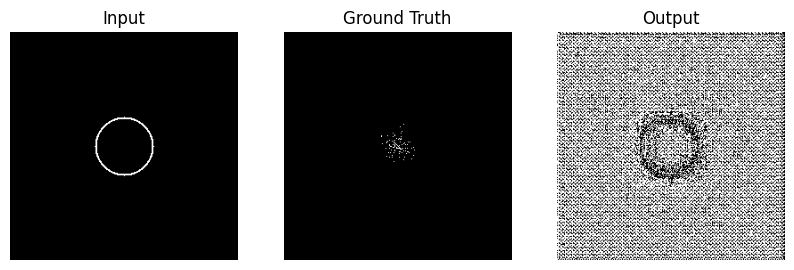

Epoch: 1


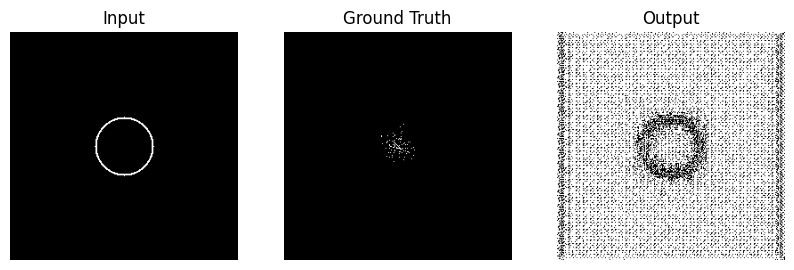

Epoch: 2


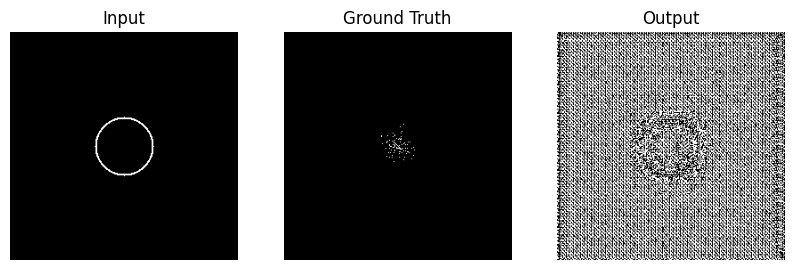

Epoch: 3


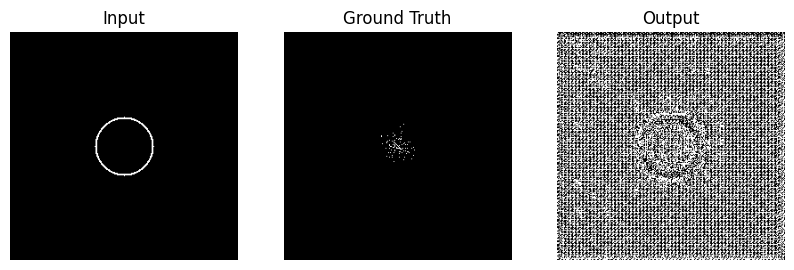

Epoch: 4


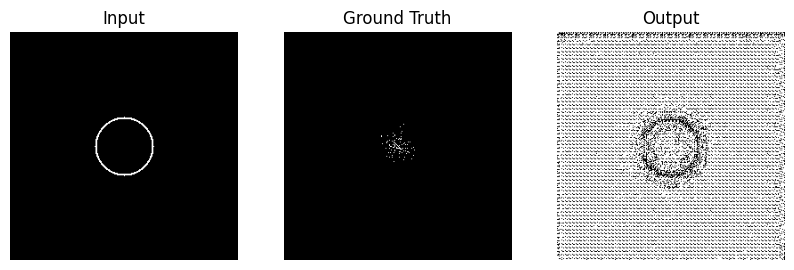

Epoch: 5


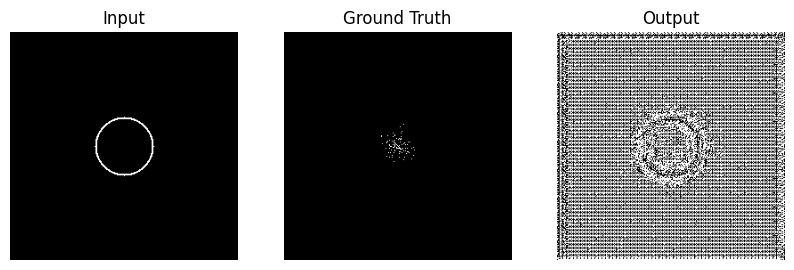

Epoch: 6


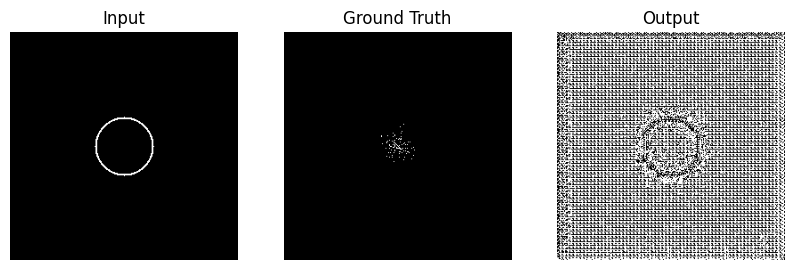

Epoch: 7


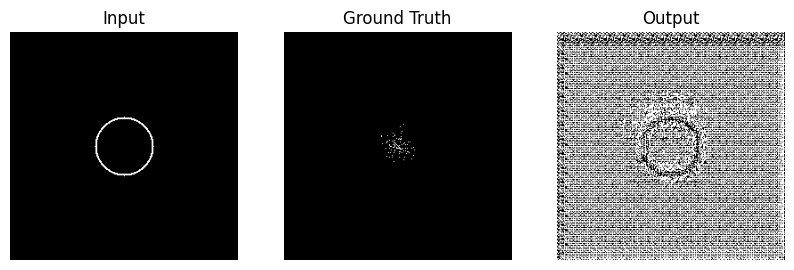

Epoch: 8


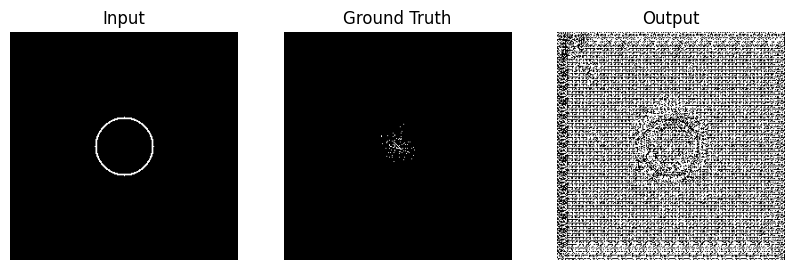

Epoch: 9


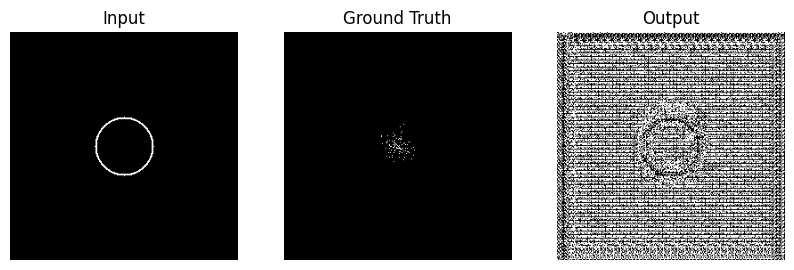

In [120]:
gen = Generator().to(device)
dis = Discriminator().to(device)
d_optimizer = torch.optim.Adam(dis.parameters(), lr=1e-4, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))

velocitys = [64, 128, 192]
widths = [16, 32, 64, 96]
dataset = PointDataset(data, widths, velocitys, 300, 0.8)
dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
real_image_batch,condition_batch = next(iter(dataloader))
real_image_batch, condition_batch = real_image_batch.to(device), condition_batch.to(device)
loss_function = nn.BCELoss()

# L1 loss
LAMBDA = 7 # L1损失权重

D_loss = []
G_loss = []

for epoch in range(10):
    beg_time = time.time()
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(dataloader)
    for step, (real_image, condition) in enumerate(dataloader):
        real_image = real_image.to(device)
        condition = condition.to(device)
        # 训练判别器
        d_optimizer.zero_grad()
        dis_real_output = dis(condition, real_image)
        d_real_loss = loss_function(dis_real_output, torch.ones_like(dis_real_output, device=device))
        d_real_loss.backward()

        gen_output = gen(condition)
        dis_gen_output = dis(condition, gen_output.detach())
        d_fake_loss = loss_function(dis_gen_output, torch.zeros_like(dis_gen_output, device=device))
        d_fake_loss.backward()

        disc_loss = d_real_loss + d_fake_loss
        d_optimizer.step()

        # 训练生成器
        g_optimizer.zero_grad()
        dis_gen_out = dis(condition, gen_output)
        gen_loss_crossentropy = loss_function(dis_gen_out, torch.ones_like(dis_gen_out, device=device))

        gen_l1_loss = torch.mean(torch.abs(gen_output - real_image))
        gen_loss = gen_loss_crossentropy + LAMBDA * gen_l1_loss
        gen_loss.backward()
        g_optimizer.step()

        with torch.no_grad():
            D_epoch_loss += disc_loss.item()
            G_epoch_loss += gen_loss.item()
    with torch.no_grad():
        D_epoch_loss /= count
        G_epoch_loss /= count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        print("Epoch:", epoch)
        generate_images(gen, condition_batch, real_image_batch)
